# Simulation comparing GLMs and NNs

## Imports

In [2]:
import numpy as np
from sklearn.cross_validation import train_test_split
from scipy import stats
import scipy.sparse as sps

# GLM
from pyglmnet import GLM

# NNs
import keras
from keras.models import Sequential
from keras.layers.core import Dense, Dropout
from keras.layers.normalization import BatchNormalization

# Plotting
import matplotlib.pyplot as plt
% matplotlib inline

## Simulate data

In [237]:
def simulate_data(n_samples, n_features, scale_min, scale_max, density, effect_size_factor):

    # Sample design matrix
    X = np.random.randn(n_samples, n_features)
    
    # Rescale
    scale_factor = np.logspace(scale_min, scale_max, n_features)
    for f in range(n_features):
        X[:, f] = scale_factor[f] * X[:, f]
    
    # Sample beta0
    beta0 = effect_size_factor * 3.0 * np.random.rand(1)
    
    # Sample sparse beta
    rvs = stats.norm(loc=0.0, scale=1.0).rvs
    tmp = sps.random(n_features, 1, density=density, data_rvs=rvs)
    beta = effect_size_factor * np.squeeze(tmp.toarray())
    
    # Sample y ~ Poisson(exp(beta0 + X * beta))
    glm_simulator = GLM(distr='softplus')
    y = glm_simulator.simulate(beta0, beta, X)
    
    return beta0, beta, X, y

In [335]:
n_samples = 1000
n_features = 10
scale_min = -2.0
scale_max = 0.0
density = 1.0
effect_size_factor = 0.5

In [336]:
beta0, beta, X, y = simulate_data(n_samples, n_features, scale_min, scale_max, density, effect_size_factor)

In [337]:
beta0, beta

(array([ 0.18241593]),
 array([-0.36710045,  0.29060202, -0.56145599, -0.42124506, -0.18574691,
        -0.43944311,  0.14134437,  0.52469813,  0.28354229,  0.24444901]))

In [338]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, test_size=0.2)

## Fit models

### GLMs 

In [339]:
glm = GLM(distr='softplus',
          alpha=0.1,
          tol=1e-8,
          reg_lambda=np.logspace(np.log(0.05), np.log(0.001), 10, base=np.exp(1)),
          learning_rate=0.01,
          solver='batch-gradient',
          max_iter=10000,
          random_state=1,
          score_metric='pseudo_R2')

In [340]:
glm.fit(X_train, y_train)
glm_r2_train = glm[-1].score(X_train, y_train)
glm_r2_test = glm[-1].score(X_test, y_test)
print glm_r2_train, glm_r2_test

[ 0.03874828] [ 0.04142872]


In [341]:
y_train_hat = glm[-1].predict(X_train)
y_test_hat = glm[-1].predict(X_test)

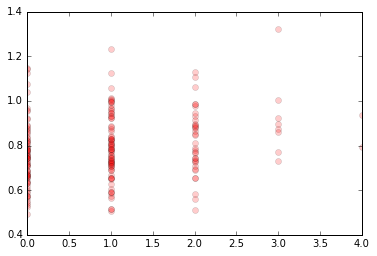

In [342]:
plt.plot(y_test, y_test_hat, 'ro', alpha=0.2)
plt.show()

## Neural Networks

In [343]:
def keras_model(n_features, n_layer1, n_layer2):
    model = Sequential()
    
    model.add(Dense(input_dim=n_features, output_dim=n_layer1, init='glorot_uniform', activation='relu'))
    model.add(Dropout(0.5))
    #model.add(BatchNormalization())
    
    model.add(Dense(input_dim=n_features, output_dim=n_layer2, init='glorot_uniform', activation='relu'))
    model.add(Dropout(0.5))
    #model.add(BatchNormalization())
    
    model.add(Dense(output_dim=1, activation='softplus'))
    
    model.compile(loss='poisson', optimizer='rmsprop')
    return model

In [344]:
nn = keras_model(n_features, 1980, 18)

In [345]:
nn.fit(X_train, y_train, nb_epoch=10, batch_size=32, validation_split=0.2)

Train on 640 samples, validate on 160 samples
Epoch 1/10
640/640 [==============================] - 0s - loss: 0.9657 - val_loss: 0.9883
Epoch 2/10
640/640 [==============================] - 0s - loss: 0.9654 - val_loss: 0.9926
Epoch 3/10
640/640 [==============================] - 0s - loss: 0.9651 - val_loss: 0.9865
Epoch 4/10
640/640 [==============================] - 0s - loss: 0.9520 - val_loss: 0.9839
Epoch 5/10
640/640 [==============================] - 0s - loss: 0.9553 - val_loss: 0.9945
Epoch 6/10
640/640 [==============================] - 0s - loss: 0.9527 - val_loss: 0.9821
Epoch 7/10
640/640 [==============================] - 0s - loss: 0.9525 - val_loss: 0.9843
Epoch 8/10
640/640 [==============================] - 0s - loss: 0.9579 - val_loss: 0.9795
Epoch 9/10
640/640 [==============================] - 0s - loss: 0.9529 - val_loss: 0.9791
Epoch 10/10
640/640 [==============================] - 0s - loss: 0.9521 - val_loss: 0.9897


In [346]:
y_train_hat = nn.predict(X_train)
y_test_hat = nn.predict(X_test)

In [347]:
def poisson_pseudoR2(y, yhat, ynull):
    eps = np.spacing(1)
    L1 = np.sum(y * np.log(eps + yhat) - yhat)
    L0 = np.sum(y * np.log(eps + ynull) - ynull)
    LS = np.sum(y * np.log(eps + y) - y)
    R2 = 1 -(LS - L1) / (LS - L0)
    return R2

In [348]:
nn_r2_train = poisson_pseudoR2(y_train, np.squeeze(y_train_hat), np.mean(y_train))
nn_r2_test = poisson_pseudoR2(y_test, np.squeeze(y_test_hat), np.mean(y_train))
print nn_r2_train, nn_r2_test

0.0556674209204 0.0208200965427


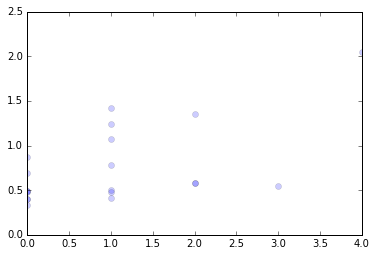

In [334]:
plt.plot(y_test, y_test_hat, 'bo', alpha=0.2)
plt.show()